In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lastversion/metadata_COVID.csv
/kaggle/input/lastversion/metadata_NORMAL.csv
/kaggle/input/lastversion/metadata_PNEUMONIA.csv
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_15_0103_02.jpg
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_02_0195_03.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_04_0012_02.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_02_0849_01.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_08_0092_03.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_13_0031_03.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_01_0034_01.jpg
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_04_0242_01.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_04_0197_01.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_02_0379_03.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous_01_0602_01.dcm
/kaggle/input/lastversion/clean_data/clean_data/Anonymous

In [6]:
!pip install pydicom


In [7]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch
import pydicom as dicom
from PIL import Image
import PIL
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, ToTensor, Normalize, Lambda, Resize
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split

In [8]:
class SmokerDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None, labeled=True):
        self.transforms = transforms
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load the image
        file_name = str(self.df['filename'].iloc[idx])
        file_path = f"/kaggle/input/lastversion/clean_data/clean_data/{file_name}"
        
        if file_name.endswith(".dcm"):
            dicom_img = dicom.dcmread(file_path)
            new_img = dicom_img.pixel_array
            scaled_image = (np.maximum(new_img, 0) / new_img.max()) * 255.0
            scaled_image = np.uint8(scaled_image)
            img = Image.fromarray(scaled_image)
        else:
            img = Image.open(file_path).convert("RGB")  

        if self.transforms:
            img = self.transforms(img)

        label = dict_label.get(self.df['smoke'].iloc[idx], -1) 

        return img, label


In [9]:
dict_label={'Yes':1, 'No':0}

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
df_normal = pd.read_csv('/kaggle/input/lastversion/metadata_NORMAL.csv')
df_covid = pd.read_csv('/kaggle/input/lastversion/metadata_COVID.csv') 
df_pneumon = pd.read_csv('/kaggle/input/lastversion/metadata_PNEUMONIA.csv') 

In [12]:
df = pd.DataFrame(pd.concat([df_covid, df_normal, df_pneumon], axis=0))
df = df.reset_index(drop=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   origin        4809 non-null   object 
 1   filename      4809 non-null   object 
 2   patient_id    4809 non-null   int64  
 3   hospital      4809 non-null   object 
 4   hospital_eng  4809 non-null   object 
 5   hospital_id   4809 non-null   int64  
 6   sex           2658 non-null   object 
 7   age           2723 non-null   float64
 8   smoke         823 non-null    object 
 9   smoke_number  160 non-null    float64
 10  class         4809 non-null   object 
 11  class_id      4809 non-null   int64  
 12  quality       4809 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 488.5+ KB


In [14]:
import os
import pandas as pd
path = '/kaggle/input/lastversion/clean_data/clean_data/'
files_in_directory = set(os.listdir(path))
df = df[df['filename'].isin(files_in_directory)]
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4230 entries, 0 to 4229
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   origin        4230 non-null   object 
 1   filename      4230 non-null   object 
 2   patient_id    4230 non-null   int64  
 3   hospital      4230 non-null   object 
 4   hospital_eng  4230 non-null   object 
 5   hospital_id   4230 non-null   int64  
 6   sex           2413 non-null   object 
 7   age           2477 non-null   float64
 8   smoke         820 non-null    object 
 9   smoke_number  159 non-null    float64
 10  class         4230 non-null   object 
 11  class_id      4230 non-null   int64  
 12  quality       4230 non-null   object 
dtypes: float64(2), int64(3), object(8)
memory usage: 429.7+ KB


In [15]:
# Extract labeled and unlabeled datasets
labeled_df = df[pd.isna(df['smoke']) == False].reset_index(drop=True)  # Rows where 'smoke' is not NaN
unlabeled_df = df[pd.isna(df['smoke']) == True].reset_index(drop=True)  # Rows where 'smoke' is NaN

# Check the datasets
print("Labeled Dataset Info:")
print(labeled_df.info())
print("\nUnlabeled Dataset Info:")
print(unlabeled_df.info())

Labeled Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820 entries, 0 to 819
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   origin        820 non-null    object 
 1   filename      820 non-null    object 
 2   patient_id    820 non-null    int64  
 3   hospital      820 non-null    object 
 4   hospital_eng  820 non-null    object 
 5   hospital_id   820 non-null    int64  
 6   sex           808 non-null    object 
 7   age           817 non-null    float64
 8   smoke         820 non-null    object 
 9   smoke_number  159 non-null    float64
 10  class         820 non-null    object 
 11  class_id      820 non-null    int64  
 12  quality       820 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 83.4+ KB
None

Unlabeled Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3410 entries, 0 to 3409
Data columns (total 13 columns):
 #   Column        Non-Null 

In [16]:

labeled_df = df[pd.isna(df['smoke']) == False].reset_index(drop=True) 
labeled_train, labeled_test = train_test_split(labeled_df, test_size=0.2, random_state=42)
labeled_train=labeled_train.reset_index(drop=True)
labeled_test=labeled_test.reset_index(drop=True)

unlabeled_df = df[pd.isna(df['smoke']) == True].reset_index(drop=True) 

print("Labeled Trai Dataset Info:")
print(labeled_train.info())
print("\nUnlabeled Dataset Info:")
print(unlabeled_df.info())

Labeled Trai Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   origin        656 non-null    object 
 1   filename      656 non-null    object 
 2   patient_id    656 non-null    int64  
 3   hospital      656 non-null    object 
 4   hospital_eng  656 non-null    object 
 5   hospital_id   656 non-null    int64  
 6   sex           646 non-null    object 
 7   age           654 non-null    float64
 8   smoke         656 non-null    object 
 9   smoke_number  121 non-null    float64
 10  class         656 non-null    object 
 11  class_id      656 non-null    int64  
 12  quality       656 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 66.8+ KB
None

Unlabeled Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3410 entries, 0 to 3409
Data columns (total 13 columns):
 #   Column        Non-

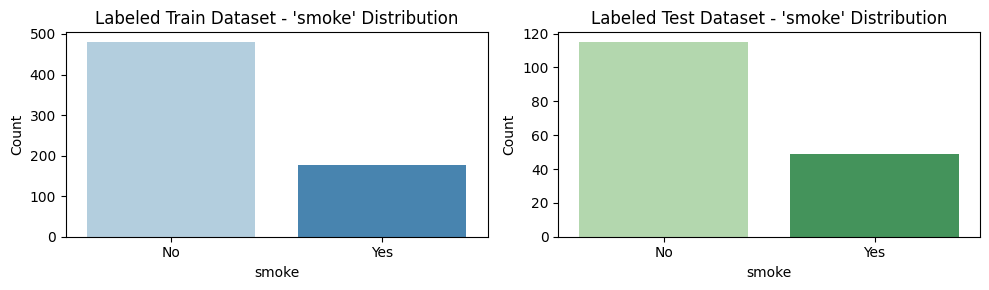

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
sns.countplot(data=labeled_train, x='smoke', palette='Blues')
plt.title("Labeled Train Dataset - 'smoke' Distribution")
plt.xlabel('smoke')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(data=labeled_test, x='smoke', palette='Greens')
plt.title("Labeled Test Dataset - 'smoke' Distribution")
plt.xlabel('smoke')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [18]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct_preds, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_preds += torch.sum(preds == labels).item()
        total += labels.size(0)
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_preds / total
    return train_loss, train_accuracy

def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss, correct_preds, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct_preds += torch.sum(preds == labels).item()
            total += labels.size(0)
    val_loss /= len(val_loader)
    val_accuracy = correct_preds / total
    return val_loss, val_accuracy

def test_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

def plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

def train_and_evaluate_model(model, train_dataset, val_dataset, test_dataset, device, 
                             criterion, optimizer, num_epochs=10, batch_size=32):

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}")
        if train_loss < best_val_loss:
            best_val_loss = train_loss
            torch.save(model.state_dict(), "best_model.pth")
    
    model.load_state_dict(torch.load("best_model.pth"))
    
    all_preds, all_labels = test_model(model, test_loader, device)
    
    report = classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"])
    print(report)
    
    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(cm, display_labels=["Class 0", "Class 1"]).plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()
    
    plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs)


In [19]:
from torch.utils.data import TensorDataset, ConcatDataset
import torch

def create_combined_dataloader(labeled_dataset, pseudo_samples, pseudo_labels, batch_size=32):
    if not isinstance(pseudo_samples, torch.Tensor):
        pseudo_samples = torch.tensor(pseudo_samples, dtype=torch.float32)
    if not isinstance(pseudo_labels, torch.Tensor):
        pseudo_labels = torch.tensor(pseudo_labels, dtype=torch.long)
    
    if isinstance(labeled_dataset, TensorDataset):
        labeled_samples, labeled_labels = labeled_dataset.tensors
    else:
        labeled_samples, labeled_labels = zip(*labeled_dataset)
        labeled_samples = torch.stack(labeled_samples, dim=0)
        labeled_labels = torch.tensor(labeled_labels, dtype=torch.long)
    
    pseudo_dataset = TensorDataset(pseudo_samples, pseudo_labels)
    
    combined_dataset = ConcatDataset([TensorDataset(labeled_samples, labeled_labels), pseudo_dataset])
    
    return combined_dataset


In [20]:
def plot_class_distribution(original_dataset, pseudo_labels, pseudo_target_class=1):
    original_counts = [0, 0]
    for _, label in original_dataset:
        original_counts[label] += 1

    pseudo_counts = [0, 0]
    pseudo_counts[pseudo_target_class] = len(pseudo_labels)
    total_counts = [original_counts[i] + pseudo_counts[i] for i in range(len(original_counts))]

    classes = ["Class 0", "Class 1"]
    x = range(len(classes))

    plt.figure(figsize=(8, 5))
    plt.bar(x, original_counts, width=0.4, label="Original Dataset", align="center")
    plt.bar(x, pseudo_counts, width=0.4, label="Pseudo-Labeled Samples", align="edge")
    plt.bar(x, total_counts, width=0.4, label="Combined Dataset", align="edge", alpha=0.6, color="orange")

    plt.xticks(x, classes)
    plt.ylabel("Sample Count")
    plt.title("Class Distribution Before and After Pseudo-Labeling")
    plt.legend()
    plt.show()


In [21]:
def ensure_rgb(image):
    if image.mode != "RGB":
        image = image.convert("RGB")
    return image


train_transform = v2.Compose([
    Lambda(ensure_rgb),
    v2.Resize((256, 256)), 
    v2.RandomCrop((224, 224)), 
    v2.RandomRotation(degrees=5), 
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    v2.ToTensor(),
])

test_transform = v2.Compose([
    # transforms.Grayscale(),
    # v2.Grayscale(),
    Lambda(ensure_rgb),
    v2.Resize((224,224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    v2.ToTensor()
    #
])


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Epoch 1/25 - Train Loss: 0.0352, Train Acc: 0.6616
Epoch 2/25 - Train Loss: 0.0273, Train Acc: 0.7348
Epoch 3/25 - Train Loss: 0.0219, Train Acc: 0.7317
Epoch 4/25 - Train Loss: 0.0176, Train Acc: 0.7409
Epoch 5/25 - Train Loss: 0.0132, Train Acc: 0.7470
Epoch 6/25 - Train Loss: 0.0116, Train Acc: 0.7713
Epoch 7/25 - Train Loss: 0.0083, Train Acc: 0.8095
Epoch 8/25 - Train Loss: 0.0075, Train Acc: 0.8537
Epoch 9/25 - Train Loss: 0.0051, Train Acc: 0.8994
Epoch 10/25 - Train Loss: 0.0038, Train Acc: 0.9207
Epoch 11/25 - Train Loss: 0.0030, Train Acc: 0.9101
Epoch 12/25 - Train Loss: 0.0017, Train Acc: 0.9466
Epoch 13/25 - Train Loss: 0.0017, Train Acc: 0.9558
Epoch 14/25 - Train Loss: 0.0018, Train Acc: 0.9299
Epoch 15/25 - Train Loss: 0.0010, Train Acc: 0.9619
Epoch 16/25 - Train Loss: 0.0009, Train Acc: 0.9543
Epoch 17/25 - Train Loss: 0.0005, Train Acc: 0.9710
Epoch 18/25 - Train Loss: 0.0003, Train Acc: 0.9756
Epoch 19/25 - Train Loss: 0.0003, Train Acc: 0.9817
Epoch 20/25 - Train L

/tmp/ipykernel_23/1302913685.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


              precision    recall  f1-score   support

     Class 0       0.76      0.90      0.82       115
     Class 1       0.57      0.33      0.42        49

    accuracy                           0.73       164
   macro avg       0.66      0.61      0.62       164
weighted avg       0.70      0.73      0.70       164



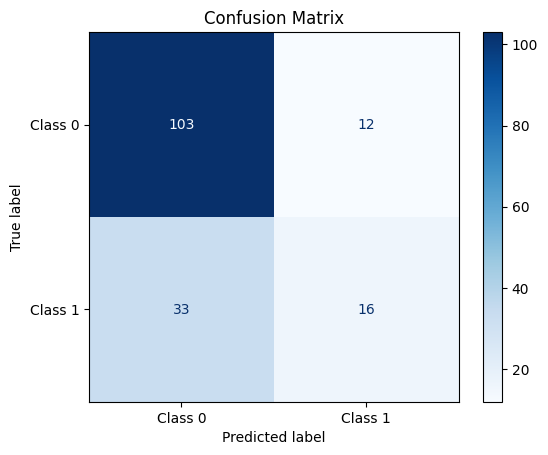

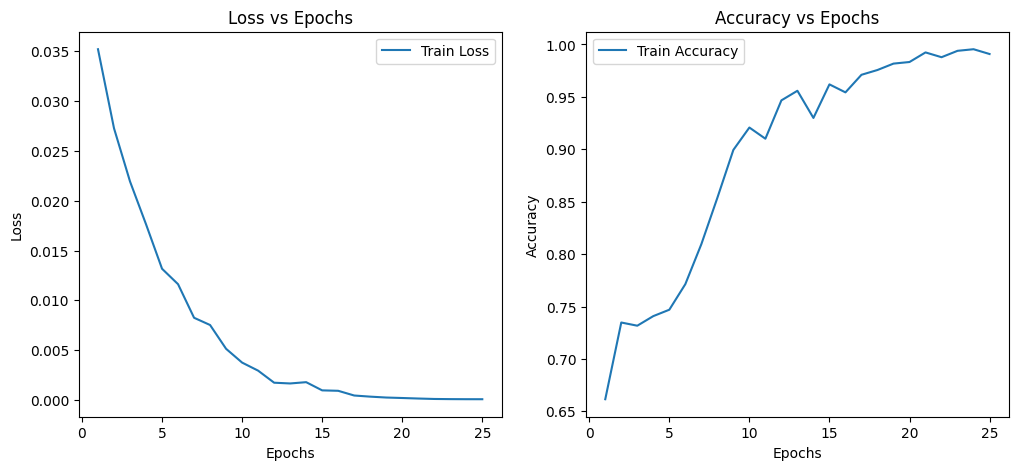

In [24]:
train_dataset = SmokerDataset(labeled_train, transforms=train_transform)
test_dataset = SmokerDataset(labeled_test, transforms=test_transform)

num_epochs = 5
best_val_loss = np.inf

model_aux = models.resnet50(weights='IMAGENET1K_V2')
model_aux = model_aux.to(device)
model_aux.fc = nn.Linear(model_aux.fc.in_features, 2).to(device) 

optimizer = optim.Adam(model_aux.parameters(), lr=0.0001)

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss

criterion = FocalLoss(alpha=0.25, gamma=2)

train_and_evaluate_model(
    model=model_aux,
    train_dataset=train_dataset,
    val_dataset=train_dataset,
    test_dataset=test_dataset,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=25,
    batch_size=64
)

In [25]:
def generate_pseudo_labels_undersampled(model, dataloader, target_class=1, threshold=0.9):
    model.eval()
    pseudo_samples, pseudo_labels = [], []
    print(f"Generating pseudo-labels for class {target_class} with confidence threshold {threshold}...")

    with torch.no_grad():
        for batch_idx, (inputs, _) in enumerate(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)
            mask = (preds == target_class) & (max_probs > threshold)
            
            # Ensure that only valid samples are appended
            if mask.any():  
                pseudo_samples.append(inputs[mask].cpu())
                pseudo_labels.append(preds[mask].cpu())

    if pseudo_samples:
        pseudo_samples = torch.cat(pseudo_samples, dim=0)
    else:
        pseudo_samples = torch.empty(0, *inputs.size()[1:])  

    if pseudo_labels:
        pseudo_labels = torch.cat(pseudo_labels, dim=0)
    else:
        pseudo_labels = torch.empty(0, dtype=torch.long)  

    print(f"Total pseudo-labeled samples for class {target_class}: {len(pseudo_samples)}")
    return pseudo_samples, pseudo_labels


In [34]:
unlabeled_dataset = SmokerDataset(unlabeled_df, transforms=train_transform)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=True, num_workers=4)
pseudo_samples, pseudo_labels = generate_pseudo_labels_undersampled(model_aux, unlabeled_loader, target_class=1, threshold=0.85)

Generating pseudo-labels for class 1 with confidence threshold 0.85...
Total pseudo-labeled samples for class 1: 236


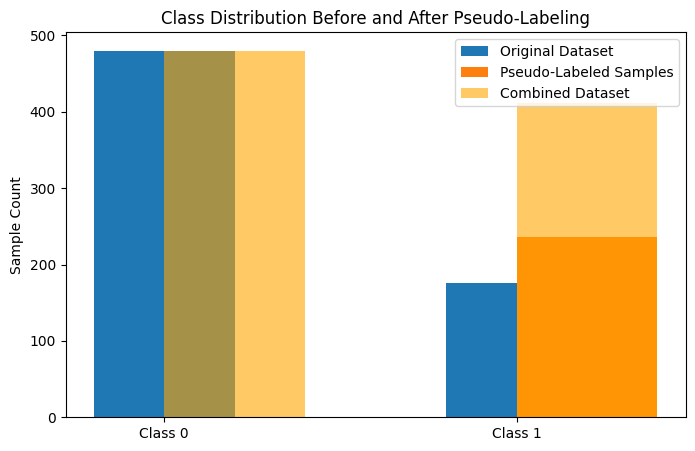

In [35]:
plot_class_distribution(train_dataset, pseudo_labels, pseudo_target_class=1)

In [36]:
combined_loader = create_combined_dataloader(train_dataset, pseudo_samples, pseudo_labels)

In [37]:
model = models.mobilenet_v3_large(weights='IMAGENET1K_V2')
model.classifier[3] = nn.Linear(in_features=1280, out_features=2)
model = model.to(device)

 Retraining the model on combined dataset
Epoch 1/10 - Train Loss: 0.0448, Train Acc: 0.4922
Epoch 2/10 - Train Loss: 0.0442, Train Acc: 0.5022
Epoch 3/10 - Train Loss: 0.0451, Train Acc: 0.5191
Epoch 4/10 - Train Loss: 0.0443, Train Acc: 0.5000
Epoch 5/10 - Train Loss: 0.0450, Train Acc: 0.4899
Epoch 6/10 - Train Loss: 0.0449, Train Acc: 0.4888
Epoch 7/10 - Train Loss: 0.0442, Train Acc: 0.5168
Epoch 8/10 - Train Loss: 0.0448, Train Acc: 0.5078
Epoch 9/10 - Train Loss: 0.0450, Train Acc: 0.4910
Epoch 10/10 - Train Loss: 0.0441, Train Acc: 0.5213


/tmp/ipykernel_23/1302913685.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


              precision    recall  f1-score   support

     Class 0       0.68      0.78      0.73       115
     Class 1       0.22      0.14      0.17        49

    accuracy                           0.59       164
   macro avg       0.45      0.46      0.45       164
weighted avg       0.54      0.59      0.56       164



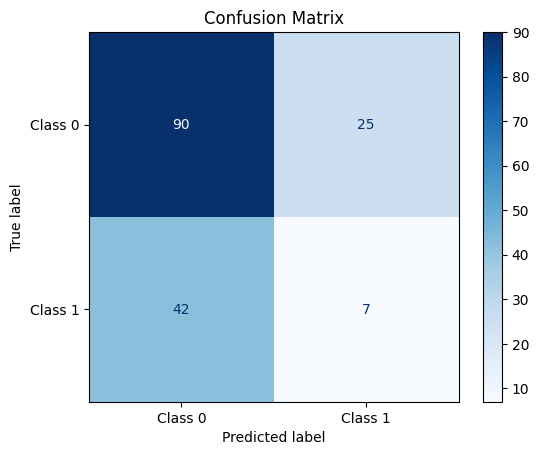

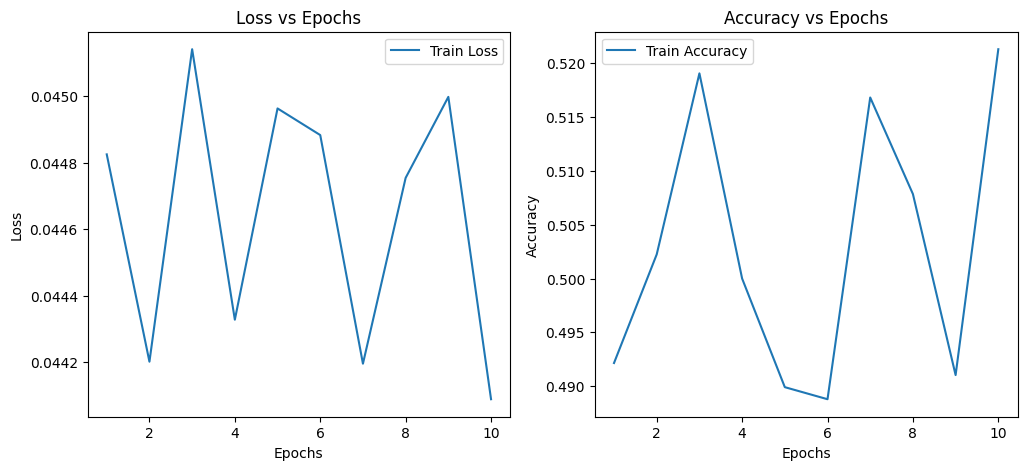

In [38]:
print(" Retraining the model on combined dataset")
train_and_evaluate_model(
    model=model,
    train_dataset=combined_loader,
    val_dataset=train_dataset,
    test_dataset=test_dataset,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    batch_size=32
)